In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split 

from sklearn.model_selection import StratifiedKFold
 
import cudf 
from cuml.linear_model import LogisticRegression
from cuml.ensemble import RandomForestClassifier


import os,glob
from src.baseline import baseline_model, evalulate_model_accuracy, cramers_v
from src.baseline.preprocess_data import down_sampling, remove_outliers

In [2]:
project_dir = os.getcwd()
data_dir = os.path.join(project_dir, 'data')

data_csv = pd.read_csv(os.path.join(data_dir, 'train.csv'))

<Axes: >

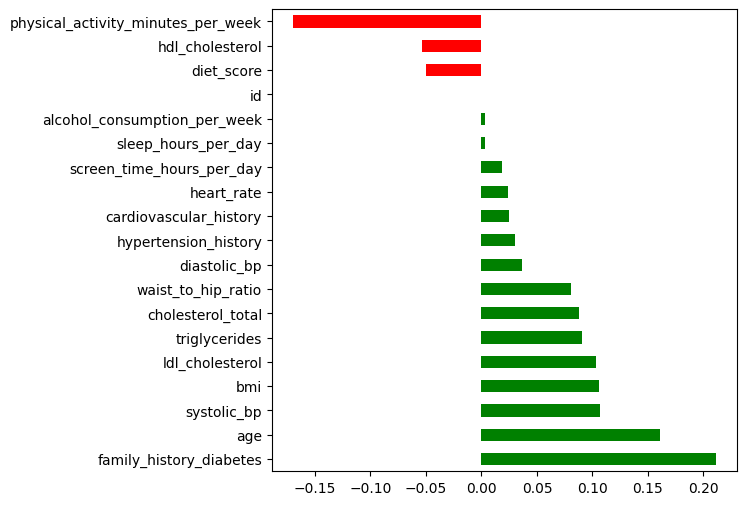

In [3]:
numerical_data  = data_csv.select_dtypes(include=[np.number])
corr_matrix     = numerical_data.corr()

fig, ax = plt.subplots(figsize=(10, 10)) 
diabetes_corr = corr_matrix['diagnosed_diabetes'].drop('diagnosed_diabetes').sort_values(ascending=False)

colors = ['green' if x > 0 else 'red' for x in diabetes_corr]
diabetes_corr.plot(kind='barh', color=colors, figsize=(6, 6)) 

In [4]:
def clinical_features(df_raw):

    df = df_raw.copy()

    ### Risk Factors ###

    df['ada_risk_factor_count'] = (
        (df['gender'] == 'Male').astype(int)
        + (df['age'] > 35).astype(int)
        + (df['bmi'] >= 25).astype(int)
        + (df['bmi'] >= 30).astype(int)
        + (df['bmi'] >= 35).astype(int)
        + (df['physical_activity_minutes_per_week'] < 100).astype(int)
        + (df['systolic_bp'] >= 130) | (df['diastolic_bp'] >= 80).astype(int)
        + (df['hdl_cholesterol'] < 35).astype(int)
        + (df['triglycerides'] > 150).astype(int)
        + df['family_history_diabetes'] 
        + df['hypertension_history']  
        + df['cardiovascular_history'] 
        )

    df['bp_normal'] = (
        (df['systolic_bp'] < 120) & 
        (df['diastolic_bp'] < 80) ).astype(int)

    # LIFE STYLE
    df['toxic_lifestyle'] = (
        (df['diet_score'] < 5).astype(int) +
        (df['sleep_hours_per_day'] < 7).astype(int) +
        (df['screen_time_hours_per_day'] > 6).astype(int) +
        (df['alcohol_consumption_per_week'] > 7).astype(int) +
        (df['physical_activity_minutes_per_week'] < 100).astype(int)
    )
     
    df['age_bmi'] = df['age'] * df['bmi']

    df['age_family_history'] = df['age'] * df['family_history_diabetes']
    df['bmi_family_history'] = df['bmi'] * df['family_history_diabetes']
    df['age_bmi_family_history'] = df['age'] * df['bmi'] * df['family_history_diabetes']
    
    # cardiovascular burden 
    df['cardio_comorbidity_count'] = (
        df['hypertension_history'] +
        df['cardiovascular_history'] +
        df['family_history_diabetes']
    )

    return df
    
data_csv2 = clinical_features(data_csv)

['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'diagnosed_diabetes', 'ada_risk_factor_count', 'bp_normal', 'toxic_lifestyle', 'age_bmi', 'age_family_history', 'bmi_family_history', 'age_bmi_family_history', 'cardio_comorbidity_count']


<Axes: >

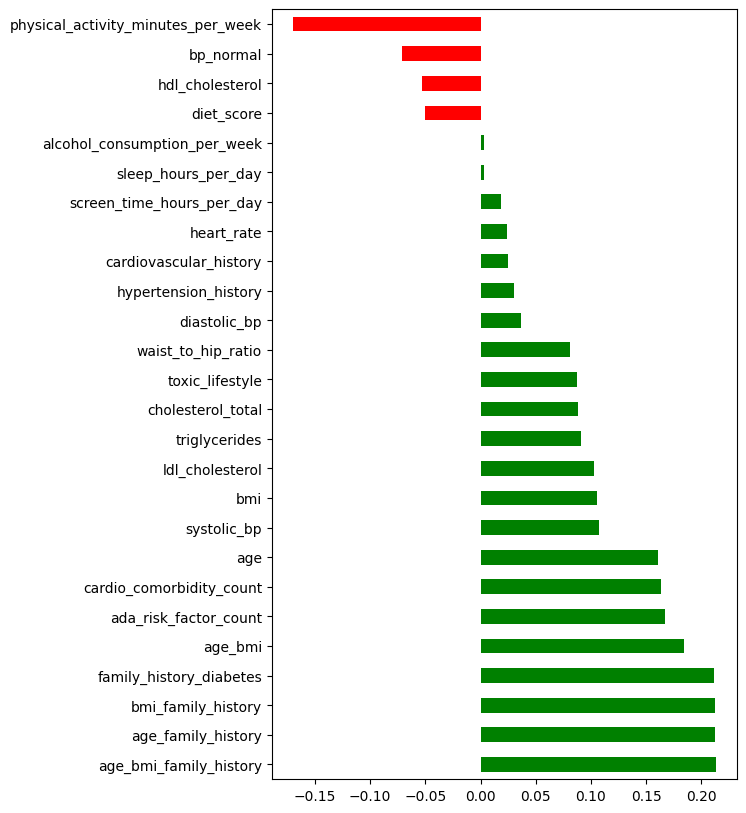

In [5]:
numerical_features = data_csv2.select_dtypes(include=[np.number]).columns.drop(['id']).tolist(); print(numerical_features)

corr_matrix = data_csv2[numerical_features].corr()
diab_corr   = corr_matrix['diagnosed_diabetes'].drop('diagnosed_diabetes').sort_values(ascending=False)

colors = ['green' if x > 0 else 'red' for x in diab_corr]
diab_corr.plot(kind='barh', color=colors, figsize=(6, 10))

In [6]:
train_data , test_data = train_test_split(data_csv2, test_size=0.2, random_state=8964)

In [9]:
models = {
    'Logistic (L2)' : LogisticRegression(penalty='l2', C=1.0, max_iter=1000),
    'Logistic (L1)' : LogisticRegression(penalty='l1', C=1.0, max_iter=1000)
}

In [17]:

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
n_fold = 5 

stratified_kfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=8964)
kfold = stratified_kfold.split(train_data, train_data['diagnosed_diabetes'])

numerical_features = train_data.select_dtypes(include=[np.number]).columns.tolist()

results = []

for i, (train_idx, valid_idx) in enumerate(kfold):
    print(f'Fold {i+1} : train_idx {len(train_idx)}, valid_idx {len(valid_idx)}')
    print('- ' * 16)

    train_inputs = train_data[numerical_features].drop(columns=['id', 'diagnosed_diabetes']).iloc[train_idx]
    valid_inputs = train_data[numerical_features].drop(columns=['id', 'diagnosed_diabetes']).iloc[valid_idx]

    train_target = train_data['diagnosed_diabetes'].iloc[train_idx]
    valid_target = train_data['diagnosed_diabetes'].iloc[valid_idx]
 

    train_inputs_gpu = cudf.DataFrame(train_inputs) 
    train_target_gpu = cudf.Series(train_target.values)  
    valid_inputs_gpu = cudf.DataFrame(valid_inputs) 
    valid_target_gpu = cudf.Series(valid_target.values)
    
    for name, model in models.items():
        model.fit(train_inputs_gpu, train_target_gpu)
        
        pred = model.predict(valid_inputs_gpu)
        pred_proba = model.predict_proba(valid_inputs_gpu)
         
        pred_proba = pred_proba.values.get()[:, 1]  
        pred = pred.values.get()  # Convert to numpy
        
        acc = accuracy_score(pred, valid_target)
        auc = roc_auc_score(valid_target, pred_proba)

        print(f"Model: {name},  Accuracy: {acc:.4f}, ROC-AUC: {auc:.4f}")
    results.append({'Fold': i, 'Model': name, 'Accuracy': acc, 'ROC-AUC': auc})
    



    # train_value_counts = train_target.value_counts()
    # train_value_counts_ratio = train_value_counts[1] / train_value_counts.sum()

    # valid_value_counts = valid_target.value_counts()
    # valid_value_counts_ratio = valid_value_counts[1] / valid_value_counts.sum()

    # print(f'[train] diagonsed_diabetes positive ratio: {train_value_counts_ratio}')
    # print(f'[valid] diagonsed_diabetes positive ratio: {valid_value_counts_ratio}')

    # log_clf, rf_clf = baseline_model(train_inputs, train_target, valid_inputs, valid_target, random_state=8964)
    # evalulate_model_accuracy(log_clf, rf_clf, valid_inputs, valid_target)

    print('-' * 16)


Fold 1 : train_idx 448000, valid_idx 112000
- - - - - - - - - - - - - - - - 
Model: Logistic (L2),  Accuracy: 0.6632, ROC-AUC: 0.6955
Model: Logistic (L1),  Accuracy: 0.6633, ROC-AUC: 0.6956
----------------
Fold 2 : train_idx 448000, valid_idx 112000
- - - - - - - - - - - - - - - - 
Model: Logistic (L2),  Accuracy: 0.6630, ROC-AUC: 0.6918
Model: Logistic (L1),  Accuracy: 0.6628, ROC-AUC: 0.6919
----------------
Fold 3 : train_idx 448000, valid_idx 112000
- - - - - - - - - - - - - - - - 
Model: Logistic (L2),  Accuracy: 0.6643, ROC-AUC: 0.6958
Model: Logistic (L1),  Accuracy: 0.6647, ROC-AUC: 0.6959
----------------
Fold 4 : train_idx 448000, valid_idx 112000
- - - - - - - - - - - - - - - - 
Model: Logistic (L2),  Accuracy: 0.6637, ROC-AUC: 0.6940
Model: Logistic (L1),  Accuracy: 0.6634, ROC-AUC: 0.6940
----------------
Fold 5 : train_idx 448000, valid_idx 112000
- - - - - - - - - - - - - - - - 
Model: Logistic (L2),  Accuracy: 0.6621, ROC-AUC: 0.6939
Model: Logistic (L1),  Accuracy: 0